Resnet Model Architecture

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the ResNet block
def resnet_block(x, filters, kernel_size=3, stride=1):
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = layers.BatchNormalization()(y)

    # Shortcut connection
    if stride > 1:
        x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)

    y = layers.add([x, y])
    y = layers.Activation('relu')(y)
    return y

# Define the ResNet model
def build_resnet_model(input_shape=(224, 224, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolution and max pooling
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual blocks
    x = resnet_block(x, 64, stride=1)
    x = resnet_block(x, 64, stride=1)
    x = resnet_block(x, 128, stride=2)
    x = resnet_block(x, 128, stride=1)
    x = resnet_block(x, 256, stride=2)
    x = resnet_block(x, 256, stride=1)
    x = resnet_block(x, 512, stride=2)
    x = resnet_block(x, 512, stride=1)
    
    # Global average pooling and fully connected layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs, x, name='resnet_model')
    return model

# Create and compile the ResNet model
resnet_model = build_resnet_model()
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
resnet_model.summary()


Model: "resnet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 64)         0         ['batch_normalizati

Hyper parameter tuning and finding the model's best parameter

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch

# Define your data directory
data_dir = "SplitData"

# Set up data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create training and validation generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Assuming it's binary classification (rot or not rot)
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Define ResNet model with hyperparameters as variables
def build_resnet_model(hp):
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights=None,
        input_shape=(224, 224, 3)
    )
    x = layers.GlobalAveragePooling2D()(base_model.output)
    
    # Tune the number of units in the dense layer
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    x = layers.Dense(units=hp_units, activation='relu')(x)

    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define the tuner and search space
tuner = RandomSearch(
    build_resnet_model,
    objective='val_accuracy',
    max_trials=5,  # You can adjust the number of trials
    directory='hyperparameter_tuning',
    project_name='basil_stem_rot'
)

# Search for the best hyperparameters
tuner.search(
    train_generator,
    epochs=5,  # Adjust as needed
    validation_data=validation_generator
)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the summary of the best model and hyperparameters
best_model.summary()
print("Best Hyperparameters:", best_hyperparameters.values)

# Save the best model
best_model.save('best_basil_stem_rot_model.h5')

Trial 5 Complete [00h 16m 25s]
val_accuracy: 0.8507462739944458

Best val_accuracy So Far: 0.8507462739944458
Total elapsed time: 02h 21m 31s
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)  

C:\Users\kaise\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Train the model (Resnet)

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch

# Define your data directory
data_dir = "SplitData"

# Set up data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create training and validation generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Assuming it's binary classification (rot or not rot)
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Define ResNet model with tuned hyperparameters
def build_resnet_model(hp):
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights=None,
        input_shape=(224, 224, 3)
    )
    x = layers.GlobalAveragePooling2D()(base_model.output)
    
    # Use tuned hyperparameters
    hp_units = hp.get('units')
    x = layers.Dense(units=hp_units, activation='relu')(x)

    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Load the best hyperparameters obtained from tuning
best_hyperparameters = {'units': 64}  # Replace this with the actual tuned hyperparameters

# Build the model with the best hyperparameters
tuned_model = build_resnet_model(best_hyperparameters)

# Train the model
tuned_history = tuned_model.fit(
    train_generator,
    epochs=50,  # Adjust as needed
    validation_data=validation_generator
)

# Save the tuned model
tuned_model.save('tuned_basil_stem_rot_model.h5')


Found 805 images belonging to 3 classes.
Found 201 images belonging to 3 classes.
Epoch 1/50
26/26 [==============================] - 215s 7s/step - loss: 0.2906 - accuracy: 0.8199 - val_loss: 0.0169 - val_accuracy: 0.8507
Epoch 2/50
26/26 [==============================] - 189s 7s/step - loss: -1.4782 - accuracy: 0.8422 - val_loss: 0.5844 - val_accuracy: 0.8507
Epoch 3/50
26/26 [==============================] - 191s 7s/step - loss: -3.2337 - accuracy: 0.8497 - val_loss: 0.0014 - val_accuracy: 0.8507
Epoch 4/50
26/26 [==============================] - 190s 7s/step - loss: -4.1588 - accuracy: 0.8497 - val_loss: 0.6112 - val_accuracy: 0.8507
Epoch 5/50
26/26 [==============================] - 188s 7s/step - loss: -9.2935 - accuracy: 0.8497 - val_loss: 4410.4326 - val_accuracy: 0.8507
Epoch 6/50
26/26 [==============================] - 189s 7s/step - loss: -15.4421 - accuracy: 0.8497 - val_loss: 183.1306 - val_accuracy: 0.8507
Epoch 7/50
26/26 [==============================] - 189s 7s/s

Test and Validate the model (Resnet)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the trained model
loaded_model = load_model('tuned_basil_stem_rot_model.h5')

# Directory paths for test and validation sets
test_dir = os.path.join(data_dir, 'test')
validation_dir = os.path.join(data_dir, 'validation')

# Function to predict the class of an image
def predict_and_display(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale to [0,1]
    
    prediction = model.predict(img_array)[0, 0]
    
    # Display the image
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    
    # Display the prediction
    plt.title(f"Prediction: {prediction:.2f}")
    plt.show()

# Evaluate on test set
test_images = os.listdir(test_dir)
for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    predict_and_display(loaded_model, img_path)

# Evaluate on validation set
validation_images = os.listdir(validation_dir)
for img_name in validation_images:
    img_path = os.path.join(validation_dir, img_name)
    predict_and_display(loaded_model, img_path)


Confusion Matrix to evaluate the performance

1/1 [==============================] - 0s 162ms/step


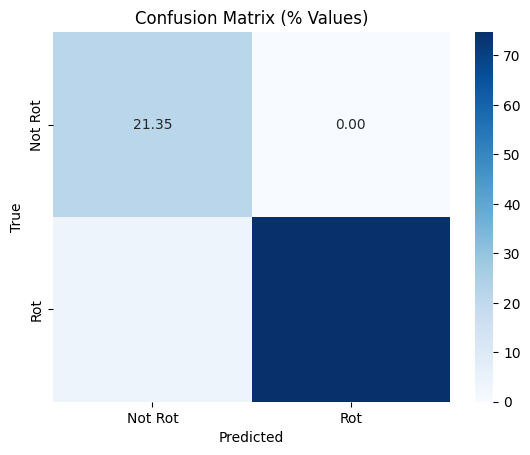

Classification Report:
               precision    recall  f1-score   support

     Not Rot       0.84      0.95      0.89       200
         Rot       0.99      0.95      0.97       700

    accuracy                           0.95       900
   macro avg       0.91      0.95      0.93       900
weighted avg       0.95      0.95      0.95       900



In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Load the trained model
loaded_model = load_model('tuned_basil_stem_rot_model.h5')

# Directory paths for test and validation sets
test_dir = 'SplitData/validation'

# Function to predict the class of an image with a threshold
def predict_image_class(model, img_path, threshold=0.5):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale to [0,1]
    prediction = model.predict(img_array)
    
    # Use threshold to classify as 0 or 1
    predicted_label = 1 if prediction[0, 0] > threshold else 0
    
    return predicted_label

# Evaluate on test set
true_labels = []
predicted_labels = []

test_images = os.listdir(test_dir)
for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    true_label = int('rot' in img_name)  # Assuming 'rot' is in the filename for the positive class
    predicted_label = predict_image_class(loaded_model, img_path, threshold=0.5)  # Adjust the threshold as needed

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)


# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Rot', 'Rot'], yticklabels=['Not Rot', 'Rot'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Not Rot', 'Rot']))

Find the accuracy of True Possitive

In [11]:
print("True Positive:",95.00 - 21.35,"%")
print("True Negative: 21.35 %\nTotal Percent: 95.00 %")

True Positive: 73.65 %
True Negative: 21.35 %
Total Percent: 95.00 %
